In [118]:
from typing import List, Dict, Any, Tuple, Union, Optional, Callable
# Modules
import requests
import json
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from bs4 import BeautifulSoup
import re
import xmlrpc.client as xc
from tqdm import tqdm
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import netwulf as wulf
import numpy as np
import math
import random

In [ ]:
# Set client to the PyPI XML-RPC server
client = xc.ServerProxy('http://pypi.python.org/pypi')

# Get a list of all the packages
pypi_packages = client.list_packages()

# lowercase all the package names
pypi_packages = [package.lower() for package in pypi_packages]

# Save the list of packages
with open("data/packages.pkl", "wb") as f:
    pickle.dump(pypi_packages, f)

In [ ]:
def get_github_link(packages: list) -> list:
    """
    Function that takes a list of python packages and returns a list of tuples with the package name, the link to the PyPI page and the link to the GitHub page.
    
    list_of_packages: list
        List of python packages to search for.
        
    return: list
        List of tuples with the package name, the link to the PyPI page and the link to the GitHub page.
    """
    
    all_links = []
    for i, package in enumerate(packages):
        # The link to the python package
        LINK = f"https://pypi.org/project/{package}/"
        
        # Get the HTML content of the page
        r = requests.get(LINK)
        
        # If the request was not successful, alert the user
        if r.status_code != 200:
            print(f"Request failed for {package, i}: {r.status_code}")
            continue
        
        # Parse the HTML content of the page
        soup = BeautifulSoup(r.content)
        
        # Get sidebar with links
        sidebar = soup.find("div", {"class": "vertical-tabs__tabs"})
        
        # Get all the links in the sidebar
        references = [link.get("href") for link in sidebar.find_all("a")]
        
        # Join into one string to regex in
        reference_text = " ".join([reference for reference in references if reference is not None])
        
        # Find the first link that contains the word "github.com"
        github_links = []
        for link in re.finditer(r"github\.com(/\w*|/\W|[-]\w*|[-]\W*)*", reference_text):
            if link.group() != "github.com/" and link.group() != "github.com":
                github_links.append(link.group())
        
        # If there are no links, append None
        if len(github_links) == 0:
            github_link = None
        
        # If there's several take the shortest and alert the user
        elif len(github_links) > 1:
            print(f"Several GitHub links found for {package, i}: {github_links}")
            github_link = min(github_links, key=len)
        
        # If there is just one link, take that out of the list
        elif len(github_links) == 1:
            github_link = github_links[0]
        
        # Else alert the user no githublink is found
        else:
            print(f"No GitHub link found for {package, i}")
            github_link = None
        
        # Append the triplet to the list
        all_links.append((package, LINK, github_link))
    
    return all_links

In [ ]:
# Load packages
with open("data/packages.pkl", "rb") as f:
    pypi_packages = pickle.load(f)

# Run the function with threadpool executor to speed up the process - still takes a loooong time so be aware
with ThreadPoolExecutor() as executor:
    all_links = list(tqdm(executor.map(get_github_link, [pypi_packages]), total=len(pypi_packages)))

# Save the list to a json file
with open("data/all_links_github.json", "w") as f:
    json.dump(all_links, f)

# Clean the list of None links
all_links_c = [(p, l, g) for p, l, g in all_links if g is not None]

with open("data/all_links_github_c.json", "w") as f:
    json.dump(all_links_c, f)

In [ ]:
with open("data/packages.pkl", "rb") as f:
    pypi_packages = pickle.load(f)
print("Number of packages on pypi:", len(pypi_packages))

with open('data/all_links_github.json', 'r') as f:
    data = json.load(f)
print("Number of packages to successfully access the webpage:", len(data))

with open('data/all_links_github_c.json', 'r') as f:
    data_clean = json.load(f)
print("Number of packages to successfully get the github link from:", len(data_clean))

In [ ]:
# For each package go to the GitHub page and get the readme.text if theres a README.md
def get_readme_text(github_link: str) -> list:
    """
    Function that takes a GitHub link and returns the text of the README.md file.
    
    github_link: str
        Link to the GitHub page.
        
    return: str
        Text of the README.md file.
    """
    # If there's no link, return None
    if github_link is None:
        return None
    
    github_link = github_link.replace("github.com", "https://raw.githubusercontent.com")
    
    try:
        response = requests.get(f"{github_link}/main/README.md")
        if response.status_code != 200:
            response = requests.get(f"{github_link}/master/README.md")
            if response.status_code != 200:
                response = requests.get(f"{github_link}/main/REAMDE.rst")
                if response.status_code != 200:
                    response = requests.get(f"{github_link}/master/REAMDE.rst")
                    if response.status_code != 200:
                        response = requests.get(f"{github_link}/main/README.txt")
                        if response.status_code != 200:
                            response = requests.get(f"{github_link}/master/README.txt")
                            if response.status_code != 200:
                                return None
                            
    except Exception as e:
        print(e)
        return None
    
    readme_text = response.text

    # Remove links which start with http
    readme_text = re.sub(r"http.*", "", readme_text)
    # Remove links to files in the repository which start with / or ./ or ../
    readme_text = re.sub(r"/.*|./.*|../.*", "", readme_text)
    # Convert /n to space
    readme_text = re.sub(r"\n", " ", readme_text)
    # Make all text lowercase
    readme_text = readme_text.lower()
    # Only keep Alphanumeric characters and - and _
    readme_text = re.sub(r"[^a-z0-9-_ ]", "", readme_text)
    # Remove multiple spaces
    readme_text = re.sub(r" +", " ", readme_text)
    # Remove empty strings
    readme_text = [line for line in readme_text.split(" ") if line != ""]

    return readme_text


def get_requirements_text(github_link: str) -> list:
    """
    Function that takes a GitHub link and returns the text of the requirements.txt file.
    
    github_link: str
        Link to the GitHub page.
        
    return: str
        Text of the requirements.txt file.
    """
    # If there's no link, return None
    if github_link is None:
        return None
    
    github_link = github_link.replace("github.com", "https://raw.githubusercontent.com")
    

    txt_bool = True
    pyproject_bool = False

    try:
        response = requests.get(f"{github_link}/main/requirements-dev.txt")
        if response.status_code != 200:
            response = requests.get(f"{github_link}/master/requirements-dev.txt")
            if response.status_code != 200:
                response = requests.get(f"{github_link}/main/dev-requirements.txt")
                if response.status_code != 200:
                    response = requests.get(f"{github_link}/master/dev-requirements.txt")
                    if response.status_code != 200:
                        txt_bool = False
                        response = requests.get(f"{github_link}/main/environment.yml")
                        if response.status_code != 200:
                            response = requests.get(f"{github_link}/master/environment.yml")
                            if response.status_code != 200:
                                pyproject_bool = True
                                response = requests.get(f"{github_link}/main/pyproject.toml")
                                if response.status_code != 200:
                                    response = requests.get(f"{github_link}/master/pyproject.toml")
                                    if response.status_code != 200:
                                        pyproject_bool = False
                                        txt_bool = True
                                        response = requests.get(f"{github_link}/main/requirements.txt")
                                        if response.status_code != 200:
                                            response = requests.get(f"{github_link}/master/requirements.txt")
                                            if response.status_code != 200:
                                                response = requests.get(f"{github_link}/main/requirements.txt")
                                                if response.status_code != 200:
                                                    return None

    except Exception as e:
        print(e)
        return None                                

    requirements_text = response.text

    # Clean the text using regex
    cleaning_reg = r"=.*|>.*|~.*|\[.*\]|;.*|<.*|!.*"

    if txt_bool:
        # Example: 
            # versioneer[toml]
            # cython~=3.0.5
            # meson[ninja]==1.2.1
            # meson-python==0.13.1
            # pytest>=7.3.2
            # pytest-cov
            # pytest-xdist>=2.2.0
            # pytest-qt>=4.2.0
        # We only want the package name and not the version or extras
        requirements_text = re.sub(r"\[.*\]", "", requirements_text)
        # Remove comments
        requirements_text = re.sub(r"#.*", "", requirements_text)
        # Clean the text using regex
        requirements_text = re.sub(f"{cleaning_reg}", "", requirements_text)
        # lower case
        requirements_text = requirements_text.lower()
        # Convert to list
        requirements_text = requirements_text.split("\n")
        # Remove trailing spaces
        requirements_text = [requirement.strip() for requirement in requirements_text]
        # Remove empty strings
        requirements_text = [requirement for requirement in requirements_text if requirement != ""]

    elif pyproject_bool:
        # Example:
            # [project]
            # name = "pydata-sphinx-theme"
            # description = "Bootstrap-based Sphinx theme from the PyData community"
            # readme = "README.md"
            # requires-python = ">=3.9"
            # dependencies = [
            # "Babel",
            # "pygments>=2.7",
            # "accessible-pygments",
            # "typing-extensions"
            # ]
            # [project.optional-dependencies]
            # doc = [
            # "numpydoc",
            # "linkify-it-py", # for link shortening
            # "rich",
            # # For examples section
            # "myst-parser"
            # ]

        # Remove comments
        requirements_text = re.sub(r"#.*", "", requirements_text)
        dependencies = re.findall(r'dependencies = \[\n(.*?)\n\]', requirements_text, re.DOTALL)
        optional_dependencies = re.findall(r'optional-dependencies\]\n.*? = \[\n(.*?)\n\]', requirements_text, re.DOTALL)
        if len(dependencies) == 0:
            return None
        if len(optional_dependencies) == 0:
            optional_dependencies = [""]
        
        dependencies = re.findall(r'".*"', dependencies[0])
        optional_dependencies = re.findall(r'".*"', optional_dependencies[0])
        requirements_text = dependencies + optional_dependencies
        # Remove double quotes
        requirements_text = [requirement[1:-1] for requirement in requirements_text]
        # Clean the text using regex
        requirements_text = [re.sub(f"{cleaning_reg}", "", requirement) for requirement in requirements_text]
        # lower case
        requirements_text = [requirement.lower() for requirement in requirements_text]
        # Remove trailing spaces
        requirements_text = [requirement.strip() for requirement in requirements_text]
        # Remove empty strings
        requirements_text = [requirement for requirement in requirements_text if requirement != ""]

    else:
        # Example:
            # name: myenv
            # channels:
            #   - defaults
            # dependencies:
            #   - numpy
            #   - pandas
            #   - pip
            #   - pip:
            #     - matplotlib
        
        # Remove comments
        requirements_text = re.sub(r"#.*", "", requirements_text)
        # Only get the dependencies which start with '- '
        requirements_text = re.findall(r"- .*", requirements_text)
        # Clean the text using regex
        requirements_text = [re.sub(f"{cleaning_reg}", "", requirement) for requirement in requirements_text]
        # lower case
        requirements_text = [requirement.lower() for requirement in requirements_text]
        # Convert to list
        requirements_text = [requirement[2:] for requirement in requirements_text]
        # Remove trailing spaces
        requirements_text = [requirement.strip() for requirement in requirements_text]
        # Remove empty strings
        requirements_text = [requirement for requirement in requirements_text if requirement != ""]

           
    return requirements_text


def node_creator(data: Tuple[str, str, str]) -> Dict[str, Any]:
    """
    Function that takes a list of tuples with the package name, the link to the PyPI page and the link to the GitHub page and returns a dictionary with the package name as the key and the value is a dictionary with the package name, the link to the PyPI page, the link to the GitHub page, the text of the README.md file and the text of the requirements.txt file.
    
    data: list
        List of tuples with the package name, the link to the PyPI page and the link to the GitHub page.
        
    return: dict
        Dictionary with the package name as the key and the value is a dictionary with the package name, the link to the PyPI page, the link to the GitHub page, the text of the README.md file and the text of the requirements.txt file.
    """
    node = {}
    
    package, link, github_link = data

    readme_text = get_readme_text(github_link)
    requirements_text = get_requirements_text(github_link)
    if requirements_text is None:
        return None
    node[package] = {"package": package, "link": link, "github_link": github_link, "readme_text": readme_text, "requirements_text": requirements_text}
    
    return node

# Test the function
test_data = ("numpy", "https://pypi.org/project/numpy/", "github.com/numpy/numpy")
test_node = node_creator(test_data)
print(test_node)

In [ ]:
# Load clean data
with open('data/all_links_github_c.json', 'r') as f:
    data_clean = json.load(f)

# Run the function with threadpool executor to speed up the process
with ThreadPoolExecutor() as executor:
    nodes = list(tqdm(executor.map(node_creator, data_clean[110000:220000]), total=len(data_clean[110000:220000])))

# Save the list to a json file
with open("data/nodes_1.json", "w") as f:
    json.dump(nodes, f)

In [ ]:
#### THIS IS THE FINAL CLEANING OF THE DATA IF NEEDED ####
with open('data/nodes_3.json', 'r') as f:
    data = json.load(f)

cleaned_data = []

for node in data:
    # lower the keys
    node = {key.lower(): value for key, value in node.items()}
    for key, value in node.items():
        value["package"] = value["package"].lower()
        value["requirements_text"] = [requirement.strip() for requirement in value["requirements_text"]]
        value["requirements_text"] = [requirement for requirement in value["requirements_text"] if requirement != ""]
        value["requirements_text"] = [requirement.lower() for requirement in value["requirements_text"]]
        value["requirements_text"] = [re.sub(r"==.*|>=.*|<=.*|~=.*|!=.*|>.*|<.*", "", requirement) for requirement in value["requirements_text"]]

    cleaned_data.append(node)


with open("data/nodes_3.json", "w") as f:
    json.dump(cleaned_data, f)

In [ ]:
# Now we make the edgelist 
# Load the data
with open('data/nodes_1.json', 'r') as f:
    nodes1 = json.load(f)
with open('data/nodes_2.json', 'r') as f:
    nodes2 = json.load(f)
with open('data/nodes_3.json', 'r') as f:
    nodes3 = json.load(f)
nodes = nodes1 + nodes2 + nodes3

edge_list = []

packages_not_in_pypi = set()

for node in tqdm(nodes):
    if node is None:
        continue
    for package in node:
        if node[package]["requirements_text"] is None:
            continue
        for requirement in node[package]["requirements_text"]:
            if requirement not in pypi_packages:
                packages_not_in_pypi.add(requirement)
                continue
            edge_list.append((requirement, package))

print("Number of packages not in PyPI:", len(packages_not_in_pypi))

# Save the edge list
with open("data/edge_list_complete.pkl", "wb") as f:
    pickle.dump(edge_list, f)

edge_list[:10]

In [ ]:
# Convert the list of dictionaries to a dictionary
nodes_dict = {}
for node in nodes:
    if node is None:
        continue
    for key, value in node.items():
        nodes_dict[key] = value

with open("data/nodes_dict.pkl", "wb") as f:
    pickle.dump(nodes_dict, f)


In [ ]:
# Load the edge list
with open("data/edge_list_complete.pkl", "rb") as f:
    edge_list = pickle.load(f)
    
G = nx.DiGraph()
G.add_edges_from(edge_list)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Number of connected components:", nx.number_weakly_connected_components(G))

In [ ]:
# Get the largest connected component
largest_cc = max(nx.weakly_connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()
print("Number of nodes in the largest connected component:", G.number_of_nodes())

In [ ]:
# Display the graph with netwulf
wulf.visualize(G)



In [ ]:
# Make a random network to compare
# Calculate the number of edges in the network
L = G.number_of_edges()

# Calculate the number of nodes in the network
N = G.number_of_nodes()

# Calculate the average degree of the network
k = 2*L/N
print(f"Average degree of the real network: {k:.2f}")

# Calculate the probability p
p = k/(N-1)

print(f"Probability of a link between two nodes: {p:.2e}")

def generate_random_network(N, p):
    # Create an empty graph
    G = nx.Graph()

    # Add N nodes
    G.add_nodes_from(range(N))

    # Add edges between nodes with probability p
    for i in tqdm(range(N-1)):
        for j in range(i+1, N):
            if np.random.uniform() < p:
                G.add_edge(i, j)
    return G

G_rand = generate_random_network(N, p)

In [ ]:
print(f'Log of N: {math.log(N)}')
print(f"Average degree of the random network: {2*G_rand.number_of_edges()/G_rand.number_of_nodes():.2f}")

In [ ]:
def make_plot(bins: list[list[int]], hists: list[list[int]], title: str, labels: list[str]):
    for bin, hist, label in zip(bins, hists, labels):
        plt.plot(bin[:-1], hist, label=label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
# Compute the distribution of degree for the random network
degree_sequence_rd = [d for _, d in G_rand.degree()]
hist_rd, bins_rd = np.histogram(degree_sequence_rd, bins=np.logspace(0, 2.2, 13), density=True)
make_plot([bins_rd], [hist_rd], 'Degree distribution of the random network', ['Random network'])

In [ ]:
# Compute the distribution of degree for the real network
degree_sequence = [d for _, d in G.degree()]
hist_r, bins_r = np.histogram(degree_sequence, bins=np.logspace(0, 2.2, 13), density=True)
make_plot([bins_r], [hist_r], 'Degree distribution of the Pypi packages network', ['Pypi packages network'])

In [ ]:
plt.axvline(k, color='black', linestyle='-', label='Real network average degree')
plt.axvline(np.mean(degree_sequence_rd), color='red', linestyle='--', label='Random network average degree')
make_plot([bins_rd, bins_r], [hist_rd, hist_r], 'Degree distribution of the real and random network', ['Random network', 'Real network'])

In [ ]:
def degree_assortativity(G):
    # k_u and k_v are the degrees of nodes u and v, respectively
    k_u = []
    k_v = []
    for u, v in G.edges():
        k_u.append(G.degree(u))
        k_v.append(G.degree(v))
    
    for x, y in G.edges():
        k_u.append(G.degree(y))
        k_v.append(G.degree(x))
    
    k_u = np.array(k_u)
    k_v = np.array(k_v)
    r = ((np.mean(k_u * k_v) - np.mean(k_u) * np.mean(k_v)) /
         (np.sqrt(np.mean(k_u**2) - np.mean(k_u)**2) * np.sqrt(np.mean(k_v**2) - np.mean(k_v)**2)))

    return r

r_degree = degree_assortativity(G.to_undirected())

print(f"Degree assortativity of the real network: {r_degree:.5f}")

In [ ]:
def configuration_model(G: nx.Graph):
    G_copy = G.copy()
    edges = list(G_copy.edges())
    idxs = list(range(len(edges)))
    num_swaps = 10 * G_copy.number_of_edges()

    for _ in range(num_swaps):
        # b. Select two edges
        idx1, idx2 = random.sample(idxs, 2)
        e1, e2 = edges[idx1], edges[idx2]

        # Ensure distinct nodes
        if len(set(e1 + e2)) < 4:
            continue

        # c. Flip the direction of e1 50% of the time
        if random.random() < 0.5:
            e1 = (e1[1], e1[0])

        # Step d: Ensure new edges do not exist
        if e1[0] not in G_copy.neighbors(e2[1]) and e2[0] not in G_copy.neighbors(e1[1]):
            
            # Step e: Remove old edges and add new edges
            G_copy.remove_edges_from([e1, e2])
            G_copy.add_edges_from([(e1[0], e2[1]), (e2[0], e1[1])])
    
            edges[idx1] = (e1[0], e2[1])
            edges[idx2] = (e2[0], e1[1])

    return G_copy

G_config = configuration_model(G.to_undirected())

In [ ]:
assert all([G.degree(node) == G_config.degree(node) for node in G.nodes])

In [ ]:
G_undir = G.to_undirected()
assortativities = []
for _ in tqdm(range(20)):
    G_config = configuration_model(G_undir)
    r_config = degree_assortativity(G_config)
    assortativities.append(r_config)

# Plot the distribution of the assortativities
plt.hist(assortativities, bins=30, label='Random networks')

# Plot the assortativity of the original network
plt.axvline(r_degree, color='red', linestyle='--', label='Real network')
plt.xlabel('Assortativity')
plt.ylabel('Frequency')
plt.title('Assortativity of the random networks')
plt.legend()
plt.show()

In [138]:
def degree_assortativity_directed(G: nx.DiGraph):
    # k_u and k_v are the degrees of nodes u and v, respectively
    # We get the k_u_in, k_u_out, k_v_in and k_v_out
    k_u_in = []
    k_u_out = []
    k_v_in = []
    k_v_out = []

    for u, v in G.edges():
        k_u_in.append(G.in_degree(u))
        k_v_in.append(G.in_degree(v))
        k_u_out.append(G.out_degree(u))
        k_v_out.append(G.out_degree(v))

    k_u_in = np.array(k_u_in)
    k_v_in = np.array(k_v_in)
    k_u_out = np.array(k_u_out)
    k_v_out = np.array(k_v_out)

    r_in_in = ((np.mean(k_u_in * k_v_in) - np.mean(k_u_in) * np.mean(k_v_in)) /
            (np.sqrt(np.mean(k_u_in**2) - np.mean(k_u_in)**2) * np.sqrt(np.mean(k_v_in**2) - np.mean(k_v_in)**2)))
    
    r_out_out = ((np.mean(k_u_out * k_v_out) - np.mean(k_u_out) * np.mean(k_v_out)) /
            (np.sqrt(np.mean(k_u_out**2) - np.mean(k_u_out)**2) * np.sqrt(np.mean(k_v_out**2) - np.mean(k_v_out)**2)))
    
    r_in_out = ((np.mean(k_u_in * k_v_out) - np.mean(k_u_in) * np.mean(k_v_out)) /
            (np.sqrt(np.mean(k_u_in**2) - np.mean(k_u_in)**2) * np.sqrt(np.mean(k_v_out**2) - np.mean(k_v_out)**2)))
    
    r_out_in = ((np.mean(k_u_out * k_v_in) - np.mean(k_u_out) * np.mean(k_v_in)) /
            (np.sqrt(np.mean(k_u_out**2) - np.mean(k_u_out)**2) * np.sqrt(np.mean(k_v_in**2) - np.mean(k_v_in)**2)))


    return r_in_in, r_out_out, r_in_out, r_out_in

r_in_in_real, r_out_out_real, r_in_out_real, r_out_in_real = degree_assortativity_directed(G)

print(f"In-in degree assortativity of the real network: {r_in_in_real:.5f}")
print(f"Out-out degree assortativity of the real network: {r_out_out_real:.5f}")
print(f"In-out degree assortativity of the real network: {r_in_out_real:.5f}")
print(f"Out-in degree assortativity of the real network: {r_out_in_real:.5f}")


In-in degree assortativity of the real network: -0.00388
Out-out degree assortativity of the real network: 0.01190
In-out degree assortativity of the real network: 0.04666
Out-in degree assortativity of the real network: -0.17131


In [122]:
def degree_correlation_directed(G: nx.DiGraph):
    # For each node with degree k' we want to get the average of neighbor degree in and neighbor degree out

    k_u_in = {}
    k_u_out = {}
    k_v_in = {}
    k_v_out = {}

    for u, v in G.edges():
        if G.in_degree(u) not in k_u_in:
            k_u_in[G.in_degree(u)] = []
        if G.out_degree(u) not in k_u_out:
            k_u_out[G.out_degree(u)] = []
        if G.in_degree(v) not in k_v_in:
            k_v_in[G.in_degree(v)] = []
        if G.out_degree(v) not in k_v_out:
            k_v_out[G.out_degree(v)] = []

    for u, v in G.edges():
        k_u_in[G.in_degree(u)].append(G.in_degree(v))
        k_u_out[G.out_degree(u)].append(G.out_degree(v))
        k_v_in[G.in_degree(v)].append(G.in_degree(u))
        k_v_out[G.out_degree(v)].append(G.out_degree(u))
    
    
    k_u_in = {k: np.mean(v) for k, v in k_u_in.items()}
    k_u_out = {k: np.mean(v) for k, v in k_u_out.items()}
    k_v_in = {k: np.mean(v) for k, v in k_v_in.items()}
    k_v_out = {k: np.mean(v) for k, v in k_v_out.items()}

    return k_u_in, k_u_out, k_v_in, k_v_out

    
k_u_in, k_u_out, k_v_in, k_v_out = degree_correlation_directed(G)
print("Average neighbor in-degree of node with in-degree k':", k_u_in)
print("Average neighbor out-degree of node with out-degree k':", k_u_out)
print("Average neighbor in-degree of node with in-degree k':", k_v_in)
print("Average neighbor out-degree of node with out-degree k':", k_v_out)
    


Average neighbor in-degree of node with in-degree k': {0: 390.70564398083235, 27: 516.75, 1: 361.2879061371841, 10: 497.0, 5: 327.00961538461536, 2: 299.0748502994012, 4: 385.3, 3: 338.1818181818182, 12: 942.5, 6: 768.4285714285714}
Average neighbor out-degree of node with out-degree k': {3: 0.028862478777589132, 6: 0.0248015873015873, 9: 0.032773780975219824, 7: 0.0499822757887274, 1: 0.027709054923305294, 2: 0.033289386947923535, 4: 0.033276450511945395, 26: 0.014423076923076924, 14: 0.036775106082036775, 11: 0.03657880580957504, 33: 0.0, 16: 0.2614182692307692, 18: 0.044662309368191724, 8: 0.02199074074074074, 17: 0.061418685121107264, 15: 0.03333333333333333, 13: 0.03909205548549811, 12: 0.030246913580246913, 19: 0.07099143206854346, 10: 0.03991031390134529, 5: 0.021592442645074223, 21: 0.07142857142857142, 29: 0.022988505747126436, 23: 0.08333333333333333, 36: 0.043859649122807015, 42: 0.22142857142857142, 62: 0.04838709677419355, 40: 0.0, 30: 0.05789473684210526, 27: 0.0787037037

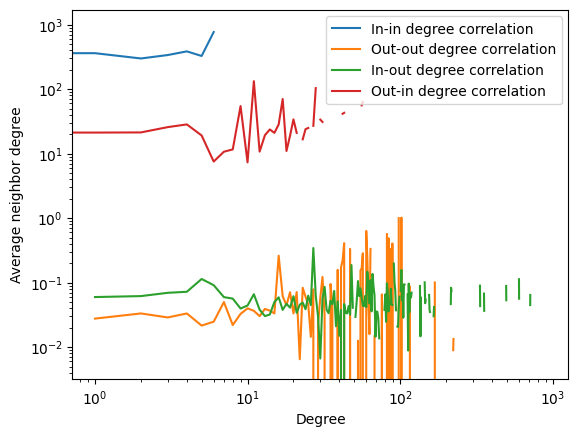

In [131]:
# Get the x values from the keys of the dictionaries
x_values = list(range(0,1000))

# Get the y values from the values of the dictionaries
y_values_in_in = [k_u_in.get(x, None) for x in x_values]
y_values_out_out = [k_u_out.get(x, None) for x in x_values]
y_values_in_out = [k_v_in.get(x, None) for x in x_values]
y_values_out_in = [k_v_out.get(x, None) for x in x_values]

# Plot the degree correlation
plt.plot(x_values, y_values_in_in, label='In-in degree correlation')
plt.plot(x_values, y_values_out_out, label='Out-out degree correlation')
plt.plot(x_values, y_values_in_out, label='In-out degree correlation')
plt.plot(x_values, y_values_out_in, label='Out-in degree correlation')

# logscale
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Degree")
plt.ylabel("Average neighbor degree")

# Place the legend top right corner
plt.legend(loc='upper right')

plt.show()



In [161]:
# We do a degree preserving randomisation : R-S randomization to the plot
def degree_preserving_randomization(G: nx.DiGraph):
    # Create a copy of the graph
    G_copy = G.copy()

    # Get the edges
    edges = list(G_copy.edges())

    # Get the number of edges
    num_swaps = 10 * G_copy.number_of_edges()

    # For each swap
    for _ in range(num_swaps):
        # Select two sets of connected
        u, v = random.choice(edges)
        x, y = random.choice(edges)

        # Ensure distinct nodes
        if len(set([u, v, x, y])) < 4:
            continue

        # Ensure that the new edges do not exist
        if x not in G_copy.neighbors(v) and y not in G_copy.neighbors(u):
            # Remove the old edges
            G_copy.remove_edges_from([(u, v), (x, y)])

            # Add the new edges
            G_copy.add_edges_from([(u, y), (x, v)])

            # Update the edges
            edges[edges.index((u, v))] = (u, y)
            edges[edges.index((x, y))] = (x, v)
        

    return G_copy

G_degree_randomized = degree_preserving_randomization(G)
k_u_in_randomized, k_u_out_randomized, k_v_in_randomized, k_v_out_randomized = degree_correlation_directed(G_degree_randomized)

x_values = list(range(0,1000))

y_values_in_in_randomized = [k_u_in_randomized.get(x, None) for x in x_values]
y_values_out_out_randomized = [k_u_out_randomized.get(x, None) for x in x_values]
y_values_in_out_randomized = [k_v_in_randomized.get(x, None) for x in x_values]
y_values_out_in_randomized = [k_v_out_randomized.get(x, None) for x in x_values]

plt.figure(figsize=(12, 10))

plt.plot(x_values, y_values_in_in, label='In-in degree correlation', color='blue')
plt.plot(x_values, y_values_out_out, label='Out-out degree correlation', color='orange')
plt.plot(x_values, y_values_in_out, label='In-out degree correlation', color='green')
plt.plot(x_values, y_values_out_in, label='Out-in degree correlation', color='red')

plt.plot(x_values, y_values_in_in_randomized, label='In-in degree correlation randomized', linestyle='None', marker = 'D', color = 'blue', markerfacecolor = 'None')
plt.plot(x_values, y_values_out_out_randomized, label='Out-out degree correlation randomized', linestyle='None', marker = 'D', color = 'orange', markerfacecolor = 'None') 
plt.plot(x_values, y_values_in_out_randomized, label='In-out degree correlation randomized', linestyle='None', marker = 'D', color = 'green', markerfacecolor = 'None')
plt.plot(x_values, y_values_out_in_randomized, label='Out-in degree correlation randomized', linestyle='None', marker = 'D', color = 'red', markerfacecolor = 'None')

plt.xscale('log')
plt.yscale('log')

plt.xlabel("Degree")
plt.ylabel("Average neighbor degree")

plt.legend(loc='upper right')

plt.show()

In [142]:
def configuration_model_directed(G: nx.DiGraph):
    G_copy = G.copy()
    edges = list(G_copy.edges())
    idxs = list(range(len(edges)))
    num_swaps = 10 * G_copy.number_of_edges()

    for _ in range(num_swaps):
        # b. Select two edges
        idx1, idx2 = random.sample(idxs, 2)
        e1, e2 = edges[idx1], edges[idx2]

        # Ensure distinct nodes
        if len(set(e1 + e2)) < 4:
            continue

        # Flip the direction of e1 50% of the time
        if random.random() < 0.5:
            e1 = (e1[1], e1[0])


        # Ensure new edges do not exist
        if e1[0] not in G_copy.neighbors(e2[1]) and e2[0] not in G_copy.neighbors(e1[1]):
            
            # Step e: Remove old edges and add new edges
            G_copy.remove_edges_from([e1, e2])
            G_copy.add_edges_from([(e1[0], e2[1]), (e2[0], e1[1])])
    
            edges[idx1] = (e1[0], e2[1])
            edges[idx2] = (e2[0], e1[1])

    return G_copy
            

In [143]:
# Do the assortativity on the config models and plot
r_in_in_config = []
r_out_out_config = []
r_in_out_config = []
r_out_in_config = []

for _ in tqdm(range(20)):
    G_config = configuration_model_directed(G)
    r_in_in, r_out_out, r_in_out, r_out_in = degree_assortativity_directed(G_config)
    r_in_in_config.append(r_in_in)
    r_out_out_config.append(r_out_out)
    r_in_out_config.append(r_in_out)
    r_out_in_config.append(r_out_in)





100%|██████████| 20/20 [02:50<00:00,  8.51s/it]


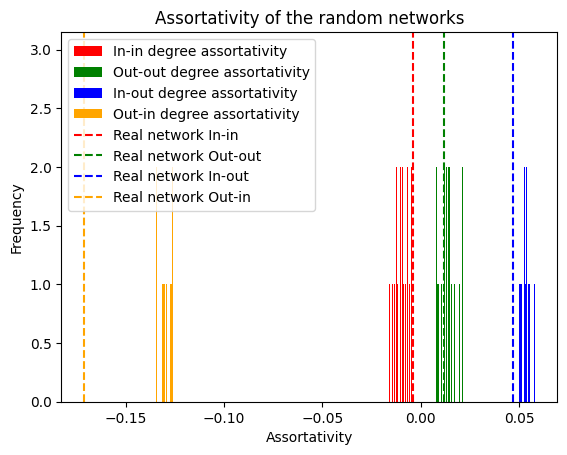

In [146]:
# Plot the distribution of the assortativities
plt.hist(r_in_in_config, bins=30, label='In-in degree assortativity', color='red')
plt.hist(r_out_out_config, bins=30, label='Out-out degree assortativity', color='green')
plt.hist(r_in_out_config, bins=30, label='In-out degree assortativity', color='blue')
plt.hist(r_out_in_config, bins=30, label='Out-in degree assortativity', color='orange')

# Plot the assortativity of the original network
plt.axvline(r_in_in_real, color='red', linestyle='--', label='Real network In-in')
plt.axvline(r_out_out_real, color='green', linestyle='--', label='Real network Out-out')
plt.axvline(r_in_out_real, color='blue', linestyle='--', label='Real network In-out')
plt.axvline(r_out_in_real, color='orange', linestyle='--', label='Real network Out-in')

plt.xlabel('Assortativity')
plt.ylabel('Frequency')
plt.title('Assortativity of the random networks')
plt.legend()
plt.show()

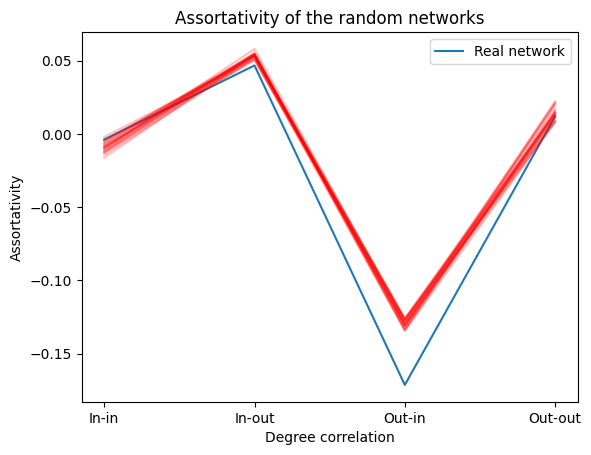

In [147]:
# Instead plot it as a line plot where the x_values are in_in, in_out, out_in, out_out:
x_values = ['In-in', 'In-out', 'Out-in', 'Out-out']

# Get the y values from the values of the dictionaries
y_values = [r_in_in_real, r_in_out_real, r_out_in_real, r_out_out_real]

fig = plt.figure()
plt.plot(x_values, y_values, label='Real network')
for i, (r_in_in, r_out_out, r_in_out, r_out_in) in enumerate(zip(r_in_in_config, r_out_out_config, r_in_out_config, r_out_in_config)):
    y_values = [r_in_in, r_in_out, r_out_in, r_out_out]
    plt.plot(x_values, y_values, alpha=0.25, color='red')

plt.xlabel("Degree correlation")
plt.ylabel("Assortativity")
plt.title("Assortativity of the random networks")
plt.legend()
plt.show()